# Sentiment Analysis of COVID-19 Vaccine Tweets

## Data Access

In [ ]:
# installs
!pip install textblob
!pip install wordcloud
!python -m textblob.download_corpora
!pip install plotly
!pip install wordninja
!pip install pyspellchecker

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 542kB 8.8MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp37-none-any.whl size=541554 sha256=2563a6cc6ca5687cbd3559b07de1bd983812d0df1a69398c670d9868fbddde6b
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import plotly.express as px

In [ ]:
df = pd.read_csv("vaccination_all_tweets.csv", quotechar='"', delimiter=',').dropna()
df

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27802,1368226947822653442,Andy The legally and popularly elected Gardener.,Untidied States,merciless infj door slammer.,2019-01-01 23:12:42,93,83,9876,False,2021-03-06 15:48:19,If you want to know how much antivaxx disinfor...,['SputnikV'],Twitter for iPhone,0,1,False
27804,1368224770995675139,🌎 Sarwar 🌐,E,W pirsarwarras,2009-07-01 00:18:11,1685,1439,6268,False,2021-03-06 15:39:40,#BREAKING \n#Venezuela \nVenezuelan President ...,"['BREAKING', 'Venezuela', 'SputnikV']",Twitter Web App,0,2,False
27806,1368224272267829256,Workout Solutions,"Toronto, Canada and Worldwide",George Tsanis – Workout Solutions Health and F...,2010-09-20 17:01:08,1164,172,1358,False,2021-03-06 15:37:41,Moscow Russia everything is open business as u...,['COVID19'],Twitter for iPhone,1,2,False
27807,1368218905353859081,William Owen,"Moscow, Russia",| political | cats | bikes | civil rights | te...,2009-03-16 03:03:13,3962,2594,51923,False,2021-03-06 15:16:21,Of course Black (spits) never mentions #Sputni...,"['SputnikV', 'ForbiddenVaccine']",Twitter Web App,0,0,False


In [ ]:
print(df.columns)
print(df.shape)

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')
(16180, 16)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16180 entries, 0 to 27808
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                16180 non-null  int64 
 1   user_name         16180 non-null  object
 2   user_location     16180 non-null  object
 3   user_description  16180 non-null  object
 4   user_created      16180 non-null  object
 5   user_followers    16180 non-null  int64 
 6   user_friends      16180 non-null  int64 
 7   user_favourites   16180 non-null  int64 
 8   user_verified     16180 non-null  bool  
 9   date              16180 non-null  object
 10  text              16180 non-null  object
 11  hashtags          16180 non-null  object
 12  source            16180 non-null  object
 13  retweets          16180 non-null  int64 
 14  favorites         16180 non-null  int64 
 15  is_retweet        16180 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.9+ MB


# Data Wrangling & Preprocessing

In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
df = df.drop_duplicates('text')
print(df.shape)

(16170, 15)


In [ ]:
# use regular expressions to strip each tweet of mentions, hashtags, retweet information, and links
def clean_tweet_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = text.lower()
    return text

# the following line makes use of an apply function-- it will call clean_tweet_text on every element in the 'text' column
df['text'].transform(clean_tweet_text)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


In [ ]:
# we do not care about the exact time of each tweet, we just want the date
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


# Exploratory Data Analysis (EDA)

In [ ]:
df.describe()

,user_followers,user_friends,user_favourites,retweets,favorites
count,1.617000e+04,16170.000000,16170.000000,16170.000000,16170.000000
mean,1.719752e+05,1518.035931,14619.516079,4.241187,18.428386
std,1.141814e+06,7640.144298,37054.083845,45.617605,246.240119
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.180000e+02,170.000000,426.000000,0.000000,0.000000
50%,9.470000e+02,492.500000,2377.000000,0.000000,1.000000
75%,4.284000e+03,1372.750000,11847.250000,1.000000,5.000000
max,1.486666e+07,380428.000000,686342.000000,2360.000000,22815.000000


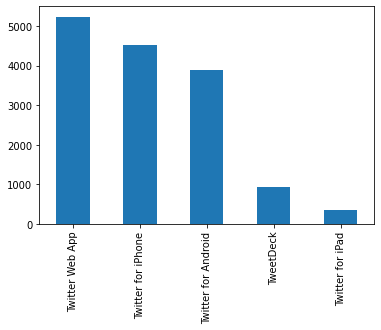

In [ ]:
# which device are people tweeting about the vaccine from?
df['source'].value_counts().head(n=5).plot.bar()

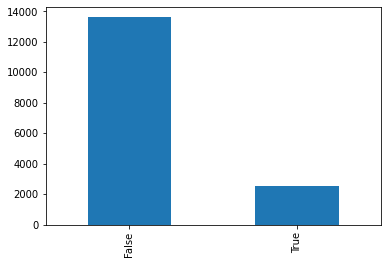

In [ ]:
df['user_verified'].value_counts().head(n=10).plot.bar()

In [ ]:
df[df['user_verified'] == True].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
15,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter for iPhone,0,1,False
17,ILKHA,Türkiye,Official Twitter account of Ilke News Agency /,2015-05-22 08:31:12,4056,6,3,True,2020-12-12,"Coronavirus: Iran reports 8,201 new cases, 221...","['Iran', 'coronavirus', 'PfizerBioNTech']",TweetDeck,3,5,False
22,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Buffer,1,0,False
43,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12,Trump announces #vaccine rollout 'in less than...,['vaccine'],Twitter Web App,0,2,False
44,Daily News Egypt,Egypt,Egypt's Only Daily Independent Newspaper in En...,2009-04-26 07:56:24,278080,116,765,True,2020-12-12,#FDA authorizes #PfizerBioNTech #coronavirus v...,"['FDA', 'PfizerBioNTech', 'coronavirus']",Twitter Web App,1,1,False


In [ ]:
# what are the top 10 most retweeted tweets
pd.set_option('display.max_colwidth', 400)
df.sort_values(by='retweets', ascending=False)[['text', 'date', 'user_name', 'user_location', 'hashtags', 'favorites', 'retweets']].head(n=10)

,text,date,user_name,user_location,hashtags,favorites,retweets
17118,"Got my jab. For the curious, it was #Covaxin. \n\nFelt secure, will travel safely. https://t.co/8PL7PZMEsf",2021-03-01,Dr. S. Jaishankar,"New Delhi, India",['Covaxin'],22815,2360
7126,"New research published in Microbiology &amp; Infectious Diseases, immunologist J. Bart Classen warns #mRNA technology u… https://t.co/OWUTf5ShHO",2021-02-10,Robert F. Kennedy Jr,"Los Angles, California",['mRNA'],3090,2247
26737,"#Covaxin 🇮🇳 , made by Hyderabad-based Bharat Biotech International Limited, has been declared ""Safe, Immunogenic wi… https://t.co/FAUOEHJmAw",2021-03-09,Megh Updates 🚨,Turn on Notification 🔔,['Covaxin'],9457,2092
17543,Prime Minister Narendra Modi choose early morning time to take #covaxin . No traffic was stopped . Traveled normall… https://t.co/udxAqk9xEC,2021-03-01,Megh Updates 🚨,Turn on Notification 🔔,['covaxin'],8153,1980
27709,This is not a queue for a Covid vaccine\nThis is a queue at a food bank today in the UK.\n#coronavirus #oxfordvaccine… https://t.co/rGqg14FT9t,2021-03-08,Afshin Rattansi,London,"['coronavirus', 'oxfordvaccine']",1713,1514
20965,#BREAKING : Bharat Biotech says its #Covaxin shows interim clinical efficacy of 81% in Phase 3 results,2021-03-03,Megh Updates 🚨,Turn on Notification 🔔,"['BREAKING', 'Covaxin']",6651,938
20575,It is tough when have to play the sauve Amrikan doctor but ur desi Lahore genes start acting up #Covaxin https://t.co/ZUygPW4WGd,2021-03-03,Manoj Rawat,New Delhi,['Covaxin'],3636,922
13101,AIIMS nurse who gave the #Covaxin jab to Prime Minister @narendramodi speaks to the national broadcaster DD News ab… https://t.co/ivPj4KGiyE,2021-03-01,Aditya Raj Kaul,"New Delhi, India",['Covaxin'],5827,870
21568,"The Opposition campaign to denigrate #Covaxin is disgraceful. So is the refusal by a coterie of senior editors, col… https://t.co/yN6M1BxvCn",2021-03-05,Minhaz Merchant,Mumbai,['Covaxin'],2311,806
20964,Phase 3 Results of #COVAXIN - announced by @BharatBiotech : Demonstrates Interim Clinical Efficacy of 81%,2021-03-03,Prof Shamika Ravi,"New Delhi, Kannauj, Kohima",['COVAXIN'],5575,773


In [ ]:
df.sort_values(by=['date', 'favorites'], ascending=[True, False])[['text', 'date', 'user_name', 'user_location', 'hashtags', 'favorites', 'retweets']].head(n=10)

,text,date,user_name,user_location,hashtags,favorites,retweets
35,An immigrant Muslim couple find the COVID-19 Vaccine. \n\n#CovidVaccine #PfizerBioNTech #Pfizervaccine #PfizerProud,2020-12-12,Shahjhan Malik | #WearAMask,"Nottinghamshire, England","['CovidVaccine', 'PfizerBioNTech', 'Pfizervaccine', 'PfizerProud']",37,2
293,#UnitedStates : The Federal Aviation Administration (FAA) said Saturday it had approved the use of the… https://t.co/xvwUEvZZk2,2020-12-12,DD News,"New Delhi, India",['UnitedStates'],21,4
25,No.1 of 2 done.\n\n#ThankYouNHS @NHSuk @MHRAgovuk and #PfizerBioNTech @pfizer for making the #CovidVaccine dream poss… https://t.co/3KvJ7UP432,2020-12-12,Devan Surendran,"Nottingham, England","['ThankYouNHS', 'PfizerBioNTech', 'CovidVaccine']",10,1
17,"Coronavirus: Iran reports 8,201 new cases, 221 deaths in the last 24 hours #Iran #coronavirus #PfizerBioNTech… https://t.co/mwDNAdmb7F",2020-12-12,ILKHA,Türkiye,"['Iran', 'coronavirus', 'PfizerBioNTech']",5,3
298,#UnitedStates : The Federal Aviation Administration (FAA) said Saturday it had approved the use of the… https://t.co/Lyq594UEks,2020-12-12,DD India,"New Delhi, India",['UnitedStates'],5,0
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2020-12-12,Gunther Fehlinger,"Austria, Ukraine and Kosovo",['vaccination'],4,0
301,I am beyond relieved to share that I’ll be among the first to receive the #CovidVaccine from #PfizerBioNTech. Thank… https://t.co/1py4jUhGzU,2020-12-12,"Taryn Schuelke, CT, CCLS","Houston, TX","['CovidVaccine', 'PfizerBioNTech']",4,2
18,.@Pfizer will rake in billions from its expensive #CovidVaccine but @AlbertBourla refuses to cut the price for lowe… https://t.co/eC94w3TUl0,2020-12-12,Braderz73🌹#GTTO 🇪🇺 🇬🇧,"Bristol, UK",['CovidVaccine'],3,3
16,UPDATED: #YellowFever &amp; #COVID19 #ImmunityPassports - Part Two\n\n#SARSCoV2 #PfizerBioNtech #Britain #December… https://t.co/qKT7Rst9aW,2020-12-12,STOPCOMMONPASS.ORG,Global,"['YellowFever', 'COVID19', 'ImmunityPassports', 'SARSCoV2', 'PfizerBioNtech', 'Britain', 'December']",2,2
21,Anyone wondering why day after #PfizerBioNTech approval in the UK people were getting vaccinated but all we are tol… https://t.co/tPSyL9CUYE,2020-12-12,"Richard Dunne, MD","Rochester, NY",['PfizerBioNTech'],2,0


# Sentiment Analysis

We will be using the `TextBlob` library to perform sentiment analysis on the tweets in our dataset. `TextBlob` provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. That said, there are numerous other packages with similar capabilities that are worth exploring, including `sklearn`, `nltk`, `vader`, `allennlp`, and more.

Let's see some short examples!

In [ ]:
testimonial = TextBlob("So excited to get my vaccine!")
print(testimonial.sentiment)
testimonial = TextBlob("Is the vaccine painful?")
print(testimonial.sentiment)
testimonial = TextBlob("The Pfizer vaccine is now FDA approved")
print(testimonial.sentiment)

Sentiment(polarity=0.46875, subjectivity=0.75)
Sentiment(polarity=-0.7, subjectivity=0.9)
Sentiment(polarity=0.0, subjectivity=0.0)


In [ ]:
testimonial = TextBlob("I tested positive for COVID-19")
print(testimonial.sentiment)

Sentiment(polarity=0.22727272727272727, subjectivity=0.5454545454545454)


In [ ]:
# tweet from Texas Governor Greg Abbott
text = """
Today Texas surpassed 8 million vaccinations. It was just 4 days ago that we passed 7 million.

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.

Hospitalizations went down again also.

Great job Texans!

Vaccines are always voluntary, never forced.
"""
blob = TextBlob(text)

In [ ]:
print("Tags")
print(blob.tags, end="\n\n")

print("Noun Phrases")
print(blob.noun_phrases, end="\n\n")

print("Words")
print(blob.words, end="\n\n")

print("Sentences")
print(blob.sentences, end="\n\n")

Tags
[('Today', 'NN'), ('Texas', 'NNP'), ('surpassed', 'VBD'), ('8', 'CD'), ('million', 'CD'), ('vaccinations', 'NNS'), ('It', 'PRP'), ('was', 'VBD'), ('just', 'RB'), ('4', 'CD'), ('days', 'NNS'), ('ago', 'RB'), ('that', 'IN'), ('we', 'PRP'), ('passed', 'VBD'), ('7', 'CD'), ('million', 'CD'), ('The', 'DT'), ('positivity', 'NN'), ('rate', 'NN'), ('dropped', 'VBD'), ('even', 'RB'), ('lower', 'JJR'), ('to', 'TO'), ('6.08', 'CD'), ('%', 'NN'), ('the', 'DT'), ('lowest', 'JJS'), ('since', 'IN'), ('May', 'NNP'), ('31st', 'CD'), ('Hospitalizations', 'NNS'), ('went', 'VBD'), ('down', 'RB'), ('again', 'RB'), ('also', 'RB'), ('Great', 'NNP'), ('job', 'NN'), ('Texans', 'NNPS'), ('Vaccines', 'NNS'), ('are', 'VBP'), ('always', 'RB'), ('voluntary', 'JJ'), ('never', 'RB'), ('forced', 'VBN')]

Noun Phrases
['texas', 'positivity rate', 'may', 'hospitalizations', 'great job', 'vaccines']

Words
['Today', 'Texas', 'surpassed', '8', 'million', 'vaccinations', 'It', 'was', 'just', '4', 'days', 'ago', 'that'

In [ ]:
for sentence in blob.sentences:
    print(sentence)
    print("polarity:", sentence.sentiment.polarity)
    print("subjectivity:", sentence.sentiment.subjectivity)
    print()


Today Texas surpassed 8 million vaccinations.
polarity: 0.0
subjectivity: 0.0

It was just 4 days ago that we passed 7 million.
polarity: 0.0
subjectivity: 0.0

The positivity rate dropped even lower--to 6.08%--the lowest since May 31st.
polarity: 0.0
subjectivity: 0.0

Hospitalizations went down again also.
polarity: -0.15555555555555559
subjectivity: 0.2888888888888889

Great job Texans!
polarity: 1.0
subjectivity: 0.75

Vaccines are always voluntary, never forced.
polarity: 0.15000000000000002
subjectivity: 0.2



In [ ]:
# let's apply the TextBlob API onto our tweet data to perform sentiment analysis!
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity
0,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False,0.00,0.125000
2,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False,0.00,0.033333
6,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False,-0.10,0.500000
9,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafianspower1\n#PoliticalScience #InternationalAffairs \n#PAKUSTV #Newyork #Islamabad,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w","['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",Twitter Web App,0,0,False,0.00,0.000000
10,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (freelance) for some companies that need analysis for their products in Int. Markets \n- Instagram : tamervisits -",2009-09-17 16:45:16,1302,78,339,False,2020-12-12,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False,0.25,0.333333


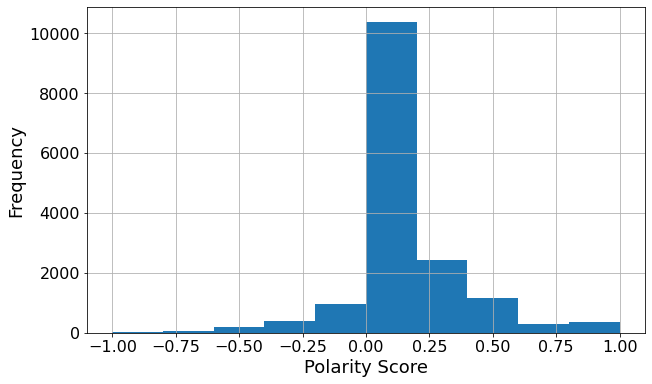

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['polarity'].hist()
plt.xlabel('Polarity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("polarity_hist.png")

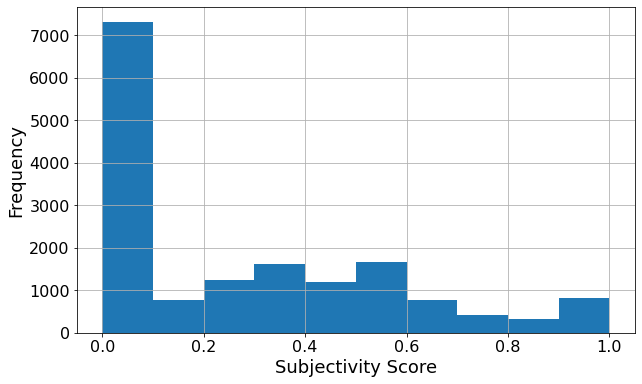

In [ ]:
fig = plt.figure(figsize=(10, 6))
df['subjectivity'].hist()
plt.xlabel('Subjectivity Score', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.savefig("subjectivity_hist.png")

## Inspection

In [ ]:
# inspect the most negatively charged tweets
df.sort_values(by='polarity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@AblemanAdam Terrible! Thank-you! And here in Canada @JustinTrudeau still will not call Russia for some #SputnikV,-1.0,1.0
1,Pharmaceutical greed at its worst...\n\n#PfizerBioNTech \n\nhttps://t.co/nT98jdzMlj,-1.0,1.0
2,"Day 4 w/#Moderna (shot 1)..\nugh, i'm miserable, but ironically i have never had any injection site pain or swelling… https://t.co/H8jo9i4wl8",-1.0,1.0
3,#Moderna side effects were terrible head aches and sore arm/injection site. The head aches may have been bc I was i… https://t.co/AWnTJP3LZB,-1.0,1.0
4,Outrageous that #Moderna #vaccine not approved in #Japan weeks ago. This isn’t the fault of #Moderna or the #EU or… https://t.co/UI0RtbMkJW,-1.0,1.0
5,Death of 23 people's in #Norway after receiving #PfizerBioNTech vaccine is pathetic and scarry too!! Autopsy report… https://t.co/N36GJTVDPP,-1.0,1.0
6,@ShamikaRavi @BharatBiotech Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Signs of #Covaxin recipients taken… https://t.co/kWLuW6tz0i,-1.0,1.0
7,@gurpreetscheema @Milan_reports @BharatBiotech @IndiaToday Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Sig… https://t.co/1Baj3QqeRk,-1.0,1.0
8,#PfizerBioNTech #Vaccin #COVID19 #Moderna \nWHAT THE FUCK !!!!!!\n😂😂😂😂🤣🤣🤣🤣🤣😱😱😱😱😱 https://t.co/NaPnpvhY5W,-1.0,0.6
9,Got my #Moderna Covid-19 vaccine dose 2 yesterday and today I feel like crap! 🤕 I do feel blessed to have had the o… https://t.co/8WfXUodIJJ,-1.0,0.8


In [ ]:
# inspect the most positively charged tweets
df.sort_values(by='polarity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,Help us win this battle - Register to get yours ! #covid19 #PfizerBioNTech #HDF https://t.co/rVbjIfQvIX,1.0,0.40
1,Questions in 🇧🇦 on whether the authorities agreed on the best conditions when buying #SputnikV🇷🇺 vaccines continue.… https://t.co/74RsA9KxwM,1.0,0.30
2,This would be great news!\n#COVID19 #vaccines #Pfizer #Moderna https://t.co/s8QCK50Pbp,1.0,0.75
3,"He took #COVAXIN, against which a lot of misinformation was spread even when it was scientifically perfect. I think… https://t.co/0RyKiFMK6l",1.0,1.00
4,Great!\n#Covaxin \n#COVID19 https://t.co/KTVPEYTHFR,1.0,0.75
5,@ARanganathan72 Excellent work #Bharat 👏\n#Covaxin \n\nCan we help our forever skeptics &amp; critics as… https://t.co/ppBYyIWKeK,1.0,1.00
6,#Covid19 Excellent news 👏👏👏\nCongratulations @BharatBiotech\n\nExpert panel recommends dropping ‘clinical trial mode’… https://t.co/eqjhQUe0Px,1.0,1.00
7,"I'm thoroughly impressed by PM @narendramodi's commitment. He took the #COVAXIN shot by #BharatBiotech, leading by… https://t.co/eQUlWc92Wb",1.0,1.00
8,Very happy to have been given the 1st dose of the #PfizerBioNTech #CovidVaccine today at @NewcastleHosps RVI. Amazi… https://t.co/SkMCQzlZZA,1.0,1.00
9,"Just got vaccinated, and feel great about it! #moderna dose 1 https://t.co/RhkBKukPfz",1.0,0.75


In [ ]:
# inspect the most subjective tweets (NOTE: subjectivity scale ranges from 0 to 1)
df.sort_values(by='subjectivity', ascending=True)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,"2nd vaccine received today, thank you @OUHospitals #PfizerBioNTech #covid19 #OneTeamOneOUH #NurseTwitter https://t.co/OoTZpQCQq8",0.0,0.0
1,"article #compares #benefits of #Pfizer, #Moderna and #Johnson and Johnson #vaccines https://t.co/FaNr6YgI2W",0.0,0.0
2,#Thursday “Ok. I was watching @12News it says the “#johnsonandjohnson #COVID19Vaccine is a one shot vaccine. Howeve… https://t.co/nx1HoyM8GL,0.0,0.0
3,Hey #Chicago..\n\nHeads up ! #COVID19 vaccine.\n\n#Moderna https://t.co/0O8Wmo92Ac,0.0,0.0
4,"For everyone passing on the #Moderna and #Pfizer vaccines to wait for the #johnsonandjohnson vaccine, please rememb… https://t.co/ChLtt6XWOv",0.0,0.0
5,The complexities of international politics hit #publichealth and #humanrights once again: \n\nSurplus #doses of… https://t.co/nxIXuDzWWb,0.0,0.0
6,$MRNA 🇺🇸 #Moderna expects $18.4 billion in 2021 sales https://t.co/ToP0BXS1bh,0.0,0.0
7,@CDCgov is lower back pain a side effect of the @moderna_tx COVID vaccine cause...\n\nOw #COVID19Vaccine #Moderna,0.0,0.0
8,Also I got second dose #COVIDVaccine today #modernavaccine #Moderna,0.0,0.0
9,Jean Marie will #Moderna-ize me https://t.co/4wfFqOmv28,0.0,0.0


In [ ]:
# inspect the most objective tweets
df.sort_values(by='subjectivity', ascending=False)[['text', 'polarity', 'subjectivity']].reset_index(drop=True).head(n=10)

,text,polarity,subjectivity
0,@Pfizer_France Here's manufacture @Pfizer_France #PfizerBioNTech ! @SanofiFR changes : 3 months to make it ! We don… https://t.co/lDNPYF5wyw,0.625,1.0
1,@KyleClark @nexton9news Important #COVID19 #vaccine question: Can someone who already received #Pfizer or #Moderna… https://t.co/MFJY5TxVsf,0.400,1.0
2,Covid: India could play an important role in producing vaccines https://t.co/RYZ9dyOXJY\n\n@Ocugen #BharatBiotech… https://t.co/vDTCpJJveH,0.400,1.0
3,Covid-19 Vaccine: Only 1 in 10 Take Jab After Four Weeks\n\n#vaccine #COVID19 #coronavirus #CoronaVaccine #India… https://t.co/K1YpYKcxJ5,0.000,1.0
4,Quote for today\nSayin' it as it is!\n#DollyParton #inspirational #Acceptance #nolimits #Moderna #jobsearcg #GoForIt… https://t.co/Gp8sSuGqVc,0.500,1.0
5,Finally got my vaccine today it hurt like a bitch and she even drew blood 😢 😝 #COVIDVaccination #oxfordastrazeneca 💉,0.000,1.0
6,"#SputnikV in India is &gt; 10 and in #Pakistan, only the businessman friend of #ImranKhan knows. https://t.co/zBTskSQ4uN",0.000,1.0
7,Never have I seen a group of people so happy in a pharmacy before or people so happy to get shots. #CovidVaccine… https://t.co/Rx7mHzGSUs,0.800,1.0
8,"@CBCNews Mayor of Nice in France asks health authorities to permit him to buy Russia #COVID19 vaccine #SputnikV, Wh… https://t.co/GZw9G5fhnN",0.600,1.0
9,I got the shot! #Moderna Relieved and happy to finally see the end for all of us 🙏 https://t.co/DTQFrAJwxH,0.400,1.0


In [ ]:
# let's inspect how many tweets there were with respect to time
timeline = df.groupby(['date']).count().reset_index()
timeline['count'] = timeline['text']
timeline = timeline[['date', 'count']]
fig = px.bar(timeline, x='date', y='count', labels={'date': 'Date', 'count': 'Tweet Count'})
fig.show()
# fig.write_image("./figures/tweet_freq_over_time.png")

# Time-Series Sentiment Analysis

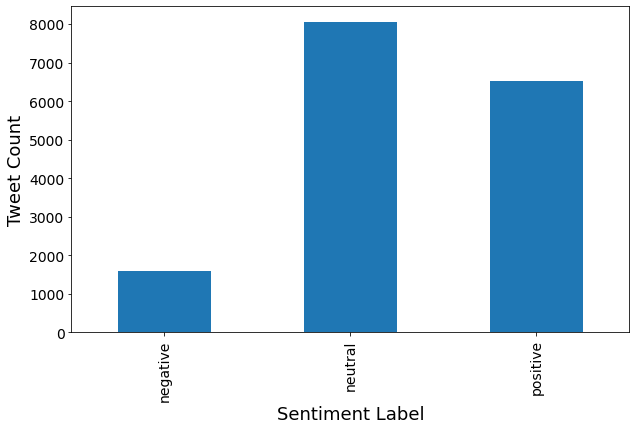

<Figure size 432x288 with 0 Axes>

In [ ]:
# polarity values ranging from -1 to 1 are really useful for sentiment analysis
# but let's convert our data to 3 classes (negative, neutral, and positive) so that we can visualize it
criteria = [df['polarity'].between(-1, -0.01), df['polarity'].between(-0.01, 0.01), df['polarity'].between(0.01, 1)]
values = ['negative', 'neutral', 'positive']
df['sentiment'] = np.select(criteria, values, 0)

# plot sentiment counts
fig = plt.figure(figsize=(10, 6))
df['sentiment'].value_counts().sort_index().plot.bar()
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Tweet Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.tight_layout()
fig.savefig("sentiment_value_counts", bbox_inches='tight');

In [ ]:
timeline = df.groupby(['date']).agg(np.nanmean).reset_index()
timeline['count'] = df.groupby(['date']).count().reset_index()['retweets']
timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
timeline["polarity"] = timeline["polarity"].astype(float)
timeline["subjectivity"] = timeline["subjectivity"].astype(float)
timeline

,date,count,polarity,retweets,favorites,subjectivity
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
2,2020-12-14,83,0.116874,4.698795,29.204819,0.267803
3,2020-12-15,87,0.094041,1.022989,7.333333,0.258078
4,2020-12-16,78,0.104020,1.000000,5.115385,0.248872
...,...,...,...,...,...,...
88,2021-03-10,465,0.098784,2.481720,9.987097,0.246851
89,2021-03-11,516,0.081946,2.232558,9.248062,0.253772
90,2021-03-12,467,0.108128,1.391863,8.509636,0.259496
91,2021-03-13,315,0.088139,3.161905,11.838095,0.290822


In [ ]:
timeline.sort_values(by='polarity', ascending=False)

,date,count,polarity,retweets,favorites,subjectivity
12,2020-12-24,70,0.184387,3.657143,17.842857,0.310656
31,2021-01-12,52,0.182608,0.961538,6.961538,0.271700
19,2020-12-31,38,0.169196,1.184211,7.342105,0.282442
16,2020-12-28,26,0.165737,1.461538,4.769231,0.292030
33,2021-01-14,64,0.163502,0.843750,6.531250,0.268629
...,...,...,...,...,...,...
55,2021-02-05,40,0.058663,0.325000,9.000000,0.195590
1,2020-12-13,52,0.055937,1.942308,7.500000,0.255696
35,2021-01-16,82,0.039450,9.670732,17.024390,0.262114
0,2020-12-12,38,0.034952,0.631579,2.868421,0.227801


In [ ]:
df[df['date'].astype(str) == '2021-01-12'][['user_location', 'date', 'text', 'hashtags', 'polarity', 'subjectivity', 'sentiment']]

,user_location,date,text,hashtags,polarity,subjectivity,sentiment
2416,Northern Ireland,2021-01-12,Delighted to receive my second vaccine today 👏🏻 #PfizerBioNTech #COVID19Vaccine https://t.co/QQOAwTG8tn,"['PfizerBioNTech', 'COVID19Vaccine']",0.350000,0.350000,positive
2531,"Nottingham, England",2021-01-12,Had my COVID-19 vaccine on Friday 💉 and experienced most of the side effects #COVIDVaccination #PfizerBioNTech \n- h… https://t.co/8zGRzftQWM,"['COVIDVaccination', 'PfizerBioNTech']",0.650000,0.700000,positive
2952,Ragbag Of Reviews And Insights,2021-01-12,#EU Plans To Purchase 300-million More #Covid19 Vaccines https://t.co/E6CxrV4yHA #covidvaccines #Pfizer… https://t.co/AKQ3vS8Dgi,"['EU', 'Covid19', 'covidvaccines', 'Pfizer']",0.500000,0.500000,positive
3121,"Corleone, Sicilia",2021-01-12,Just had my first #COVIDVaccination #COVID19 I am now 70% immortal #PfizerVaccine #PfizerBioNTech #Pfizer,"['COVIDVaccination', 'COVID19', 'PfizerVaccine', 'PfizerBioNTech', 'Pfizer']",0.250000,0.333333,positive
3124,"London, UK",2021-01-12,Getting vaccinated today. ☺️ #PfizerBioNTech,['PfizerBioNTech'],0.000000,0.000000,neutral
3128,"Vienna, Dublin, & Cyberspace",2021-01-12,@AvilaLipsett @jessica_anhold Woefully behind other countries. #Israel way ahead; smartly ordered #PfizerBioNTech i… https://t.co/OMTNQcGygC,"['Israel', 'PfizerBioNTech']",-0.103571,0.572619,negative
3131,UK,2021-01-12,#Covid-19 vaccines are from \n\n#PfizerBioNTech --- ? -70C £15\nUniversity of #Oxford and #AstraZeneca -- fridg… https://t.co/6sUEmVUToI,"['Covid', 'PfizerBioNTech', 'Oxford', 'AstraZeneca']",0.000000,0.000000,neutral
3132,"South West, England",2021-01-12,"Had my first dose of #PfizerBioNTech vaccine today at @RUHBath, truly impressed to see the arrangements. High prais… https://t.co/V9EwDUGZwW",['PfizerBioNTech'],0.470000,0.624444,positive
3133,"Southampton, England",2021-01-12,There isn't enough words to say how grateful I am to have received the first #COVID19Vaccine #PfizerBioNTech today… https://t.co/Y9iUS8J5Xc,"['COVID19Vaccine', 'PfizerBioNTech']",0.125000,0.416667,positive
3134,Belgium,2021-01-12,Discover today's front pages of the #BelgianPress 🗞📅🧐!\n#MbayeLeye #Standard #variantecovid #Variant #DogStudio… https://t.co/LttvTIDAnp,"['BelgianPress', 'MbayeLeye', 'Standard', 'variantecovid', 'Variant', 'DogStudio']",0.000000,0.000000,neutral


In [ ]:
# Plot tweets over time, color-coded by average polarity score
fig = px.bar(timeline, x='date', y='count', color='polarity')
fig.show()

In [ ]:
# # Plot tweets over time, color-coded by average subjectivity score
fig = px.bar(timeline, x='date', y='count', color='subjectivity')
fig.show()

# Filter by Vaccy

In [ ]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Function to filter the data to a single vaccine and plot the timeline
# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine-- not very helpful!
def filter_by_vaccy(df, vax):
    df_filt = pd.DataFrame()
    for v in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(v)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
#     df_filt = df_filt.drop_duplicates()
    timeline = df_filt.groupby(['date']).agg(np.nanmean).reset_index()
    timeline['count'] = df_filt.groupby(['date']).count().reset_index()['retweets']
    timeline = timeline[['date', 'count', 'polarity', 'retweets', 'favorites', 'subjectivity']]
    timeline["polarity"] = timeline["polarity"].astype(float)
    timeline["subjectivity"] = timeline["subjectivity"].astype(float)
    return df_filt, timeline

In [ ]:
pfizy_df, pfizy_timeline = filter_by_vaccy(df, ['pfizer', 'biontech'])
print(pfizy_df.shape)
fig = px.bar(pfizy_timeline, x='date', y='count', color='polarity')
fig.show()

(5454, 18)


In [ ]:
moderna_df, moderna_timeline = filter_by_vaccy(df, ['moderna'])
print(moderna_df.shape)
fig = px.bar(moderna_timeline, x='date', y='count', color='polarity')
fig.show()

(2604, 18)


In [ ]:
astra_df, astra_timeline = filter_by_vaccy(df, ['astrazeneca'])
astra_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment
0,Ricarda Milstein,Hamburg - Berlin,Health Economist @unihh/@hche_uhh. Passion for Asia and baroque music. All views are my own. RT ≠ endorsement.,2014-09-24 20:22:30,388,387,3863,False,2021-02-17,The @tagesspiegel reports that only 2% of 🇩🇪 would choose #AstraZeneca. Thank god it's not that bad: Approx. 50% ar… https://t.co/ZE2hnjtGTG,['AstraZeneca'],Twitter Web App,8,10,False,-0.350000,0.833333,negative
1,Bart Kulpa,"London, UK","Globally-minded person working for an international law firm. Enjoy debate on law, politics and foreign affairs 🇪🇺🇵🇱🇬🇧",2014-03-14 15:46:47,3951,3938,40651,False,2021-03-05,"In AstraZeneca spat, EU fights hard for a vaccine it's hardly using https://t.co/430WB67N7a #Europe #EU… https://t.co/FQVqMKZMyw","['Europe', 'EU']",Twitter for Android,1,0,False,-0.291667,0.541667,negative
2,Anurag Sinha,"Ottawa, Canada",International Affairs; Itinerant ✈️🇲🇹 ✈️ 🇬🇧 ✈️ 🇶🇦✈️ 🇵🇱 ✈️ 🇩🇪 ✈️ 🇪🇸 ✈️ 🇦🇹 ✈️🇨🇭✈️ 🇨🇾,2008-11-04 14:47:14,360,3314,5546,False,2021-02-10,@szarabi Not sure what you mean by India-made. #AstraZeneca has been approved @GovCanHealth. We in #Canada don’t re… https://t.co/Rjy8VvWYNu,"['AstraZeneca', 'Canada']",Twitter for iPhone,0,2,False,-0.281250,0.788194,negative
3,EurAsian Times,Global,"EurAsian Times provides Latest International News and Analysis besides Empowering People to Report, Review & Publish Online Consumer Complaints.",2014-11-18 09:13:11,3017,132,3,False,2021-03-03,#Malaysia granted conditional approval for the use of coronavirus vaccines produced by #UK firm #AstraZeneca and… https://t.co/thlavGJdsJ,"['Malaysia', 'UK', 'AstraZeneca']",Twitter Web App,1,1,False,-0.200000,0.400000,negative
4,Michael Wynne,Bahrain,Views and opinions are my own. You are entitled to your own.,2011-02-09 00:47:27,192,725,3668,False,2021-03-04,@caulmick Independent... me hole... Seriously the EU has been screwed over by #AstraZeneca and people will end up i… https://t.co/e6BmyoFuzz,['AstraZeneca'],Twitter for iPhone,1,1,False,-0.166667,0.395833,negative
5,India Post,"Fremont, CA, USA",Refresh yourself every morning with India Post news coverage Use#IndiaPostNewsPaper to get featured\nContribute your articles here: https://t.co/yuBlQ7dX1S…,2009-03-24 20:03:31,628,699,15,False,2021-02-08,AstraZeneca's vaccine less ... - https://t.co/TE9RYY5PgP \nGet your news featured use #IndiaPostUSA \n#AnthonyFauci… https://t.co/BjG0kZHBfe,"['IndiaPostUSA', 'AnthonyFauci']",IndiaPost,0,0,False,-0.166667,0.066667,negative
6,Ramon Denz,Gaza,Free Palestine - Friend of Muslims - ANTI Racism and Fascism - can't stand stupid people - 9/11 was an inside job!\nAKASHIC VAULT,2020-07-08 10:09:23,263,502,10990,False,2021-02-08,"#AstraZeneca proofs to be NOT functioning at all, and pointless to take to stop #Corona. How long will it take befo… https://t.co/etBr4YqlSJ","['AstraZeneca', 'Corona']",Twitter Web App,0,0,False,-0.150000,0.450000,negative
7,Dr George Christos,"Perth, Western Australia","theoretical physicist/mathematician/neuroscientist/author artist/builder/architectural artist\n2020s: #covid19 covidologist, go4 #zerocovid",2015-05-31 11:15:30,861,89,7199,False,2021-03-05,i still cannot see what we are using #AstraZeneca #vaccine which has a much lower #efficacy and useless against som… https://t.co/jbS1JTBg5o,"['AstraZeneca', 'vaccine', 'efficacy']",Twitter Web App,0,1,False,-0.150000,0.200000,negative
8,🕷Financial Bear 3.5%,#KeepFightingMichael,"Pro the EU for the opportunities it offers citizens.Lower tax,less authority, power to the people not politicians. Love coffee,running, Formula-E",2012-03-10 08:03:36,1677,899,29431,False,2020-12-30,#AstraZeneca vaccine is going to have a communications nightmare due to their rush under government pressure to rel… https://t.co/qyt1Vt3Bga,['AstraZeneca'],Twitter Web App,1,0,False,-0.1250

In [ ]:
covaxin_df, covaxin_timeline = filter_by_vaccy(df, ['covaxin'])
covaxin_df.sort_values(by='polarity', ascending=True).reset_index(drop=True).head(n=20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,polarity,subjectivity,sentiment
0,Prasenjit Bhakat,"Jhargram,W Bengal,India","Past President (2011-12): Rotary Jhargram Green, Rotary Int'l Dist 3291;\r\n \r\n\r\n\r\n\r\n\r\n\r\n\r\nConsumer Activist,Secretary: Consumer Guidance Center.",2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@ShamikaRavi @BharatBiotech Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Signs of #Covaxin recipients taken… https://t.co/kWLuW6tz0i,"['clinicaltrials', 'COVID19Vaccine', 'Covaxin']",Twitter Web App,0,0,False,-1.000000,1.000000,negative
1,Prasenjit Bhakat,"Jhargram,W Bengal,India","Past President (2011-12): Rotary Jhargram Green, Rotary Int'l Dist 3291;\r\n \r\n\r\n\r\n\r\n\r\n\r\n\r\nConsumer Activist,Secretary: Consumer Guidance Center.",2009-08-31 02:14:30,390,1658,5071,False,2021-03-03,@gurpreetscheema @Milan_reports @BharatBiotech @IndiaToday Shocking #clinicaltrials of COVAXIN #COVID19Vaccine. Sig… https://t.co/1Baj3QqeRk,"['clinicaltrials', 'COVID19Vaccine']",Twitter Web App,0,0,False,-1.000000,1.000000,negative
2,Balaji,Bengaluru,"Classical Liberal. Wry wit, that usually fails.",2008-08-07 17:03:25,487,148,5278,False,2021-03-01,Prime Moron.\n\nTerrible advertisement for research in India when the Prime Minister takes #Covaxin which was not exp… https://t.co/kAdzjuVTXN,['Covaxin'],Twitter for iPhone,0,1,False,-0.900000,1.000000,negative
3,Dilip Jain | दिलीप जैन 🇮🇳,"Bengaluru, India",Entrepreneur ● Love Cooking ● Blessed To Be Followed By PM Narendra Modi & Sh Amit Shah ● #JaiHind 🇮🇳,2010-05-09 18:31:09,13869,410,80561,False,2021-03-01,"@tinucherian @narendramodi Hello hate machine, its Bharath Biotech #COVAXIN https://t.co/ZeeDowMLbs",['COVAXIN'],Twitter for Android,5,133,False,-0.800000,0.900000,negative
4,Balaji Ganesan,"Bengaluru, India","Engineer @IBMResearch. Interested in Knowledge Graphs, NLP and Information Retrieval.",2010-06-19 08:20:41,373,370,868,False,2021-03-01,"Nature doesn’t play dice.\n\nIn India, Govt does. To choose whether a person gets #covishield or #Covaxin.\n\nBad adver… https://t.co/HEct4o0syr","['covishield', 'Covaxin']",Twitter for iPhone,0,2,False,-0.700000,0.666667,negative
5,#SETTARGETS 🎯,"London, England","⏳ It's a marathon, not a sprint. 💎 Do your own DD and #TAKEPROFIT —— $IDEX $OCGN $CBBT $NIO $ACIC $LAC $LTMCF ⚡️ $LINK $ETH $BTC",2021-01-04 12:59:10,57,157,731,False,2021-03-01,WHERE THE FUCK IS @CNN NOW! Report on this news about #COVAXIN you idiots. $OCGN https://t.co/Bhwxbm0jOy,['COVAXIN'],Twitter for iPhone,0,5,False,-0.650000,0.700000,negative
6,NAV BHARAT,"New Delhi, India",जाति 👉 प्रातः- शूद्र || फिर ब्राह्मण || फिर वैश्य || और देशद्रोहियों के लिए सदैव क्षत्रिय।,2014-01-05 15:15:18,292,750,11592,False,2021-03-04,Request @theJagmeetSingh to have one made in india vaccine into his fucking ass also... 😜 #Covaxin #CoronaVaccine… https://t.co/iM1HPSJhWJ,"['Covaxin', 'CoronaVaccine']",Twitter for iPhone,1,1,False,-0.600000,0.800000,negative
7,ब्रह्मराक्षस👹,Gorakhpur & New Delhi,"∣ ɴᴀᴛɪᴏɴ ғɪʀsᴛ 🇮🇳 |\n॥एकोऽहम् द्वितीयो नास्ति, न भूतो न भविष्यति॥\n#DelhiUniversity (Hons.) Chemistry⚗\n| Rajdhanian | In Search of My Destiny ∣ memes❤️ |",2018-09-24 15:09:08,1065,1015,1831,False,2021-03-01,When you are afraid of taking injection bt there are girls all around you😜😆🤣\n#Covaxin #CoronaVaccine… https://t.co/8rlezlrBBn,"['Covaxin', 'CoronaVaccine']",Twitter for Android,0,2,False,-0.600000,0.900000,negative
8,MaryRobotic,"California, United States","Mask-loving, Trump-hating liberal\nopposed to genetic vaccines🌲🌲\nWarp Speed denied U.S. access \nto traditional vaccines.\nUntil a vaccine there's Ivermectin",2019-03-25 17:58:43,79,1,9461,False,2021-03-02,@Yalpanam10 @bsindia Please send all of the #Covaxin doses that you don't want over to the U.S. We are desperate h… https://t.co/rgqTS0YhMV,['Covaxin'],Twitter Web App,0,2,False,-0.600000,1.0